In [1]:
import math
import random
from collections import defaultdict
from pprint import pprint

# Prevent future/deprecation warnings from showing in output
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set global styles for plots
sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

In [21]:
path_to_file = "bloodclot_controversy_coding_VALIDATION_actor.csv"

In [25]:
df = pd.read_csv(path_to_file, encoding='utf-8')
df.head()

,headline,label
0,"[UPDATE] @DrZweliMkhize: ""In South Africa, we ...",4
1,"[UPDATE] @DrZweliMkhize: ""In South Africa, we ...",4
2,4:27pm - SA publishes vaccination roadmap incl...,4
3,#BREAKING: Health Canada says a new and extrem...,2
4,Ever thought of blood clots before #smoking? T...,2


In [26]:
df = df[df.label != 5]
df.label.value_counts()

2    23592
4    19639
1     7861
3      361
Name: label, dtype: int64

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
vect = CountVectorizer(max_features=1000, binary=True)
X = vect.fit_transform(df.headline)

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
from sklearn.model_selection import train_test_split

X = df.headline
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)

In [31]:
counts = df.label.value_counts()
print(counts)

print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))

2    23592
4    19639
1     7861
3      361
Name: label, dtype: int64

Predicting only 1 = 15.28% accuracy


In [32]:
from imblearn.over_sampling import SMOTE #install via powershell pip install -U imbalanced-learn

In [33]:
sm = SMOTE()

In [34]:
X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)#if you copy paste, change sample to resample

In [35]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(1, 18804), (2, 18804), (3, 18804), (4, 18804)]


In [36]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.7869336311423102

In [37]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([2, 2, 4, ..., 4, 2, 2], dtype=int64)

In [62]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred, average="micro") * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 76.60%

F1 Score: 76.60

COnfusion Matrix:
 [[ 873  201  120  382]
 [ 118 3794  124  759]
 [   3   17   38    8]
 [ 195  332  149 3178]]


In [63]:
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))


COnfusion Matrix:
 [[ 873  201  120  382]
 [ 118 3794  124  759]
 [   3   17   38    8]
 [ 195  332  149 3178]]


In [65]:
from sklearn.model_selection import ShuffleSplit

X = df.headline
y = df.label

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample - change from sample to resample
    X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average = "micro"))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 76.40%

Average F1 score across folds: 76.40%

Average Confusion Matrix across folds: 
 [[ 889.   185.   117.9  374.2]
 [ 121.9 3693.3  124.   769.3]
 [   5.5   14.1   45.5   10.4]
 [ 251.2  315.8  138.9 3235. ]]


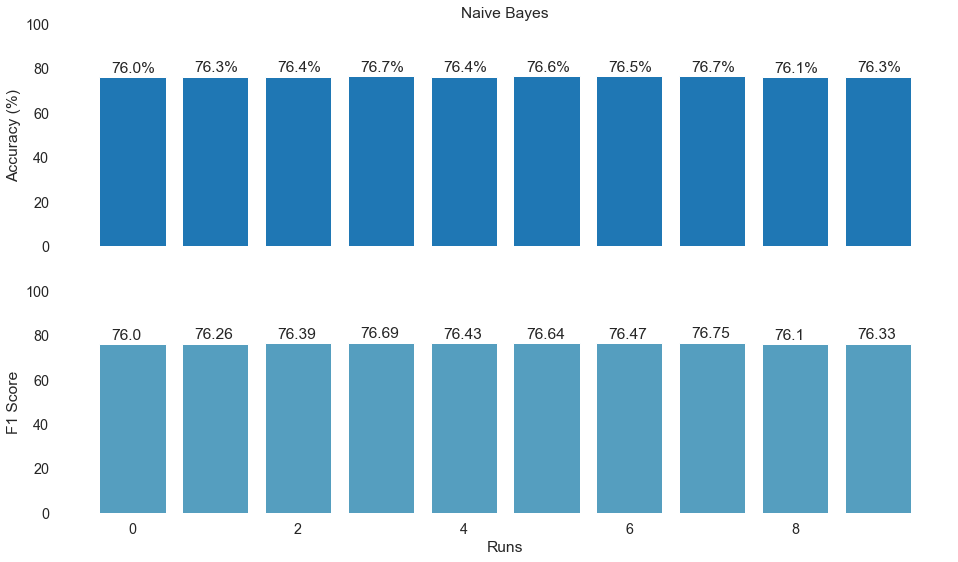

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

In [25]:
new_tweets = "go_tweets.csv"

In [27]:
X_new = vectorizer.transform(new_tweets)
classifier.fit(X_train

SyntaxError: invalid syntax (<ipython-input-27-747c88fc5feb>, line 2)